In [5]:
%pip install umap-learn
%pip install umap-learn[plot]
%pip install umap-learn[parametric_umap]

  Using cached umap_learn-0.5.6-py3-none-any.whl.metadata (21 kB)
  Using cached scipy-1.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.7 MB/s eta 0:00:00
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached umap_learn-0.5.6-py3-none-any.whl (85 kB)
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
Using cached scikit_learn-1.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
Using cached scipy-1.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 1.8 MB/s eta 0:00:00a 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (

In [ ]:
%pip install importlib-metadata==4.9.*

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2023.8.1 requires importlib-metadata>=4.13.0, but you have importlib-metadata 4.9.0 which is incompatible.


In [18]:
%pip install numba tensorflow netCDF4

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pdb
import glob
import math
# import umap
import numba
# import umap.plot
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc 
import datetime as dt
import tensorflow as tf
import matplotlib as mpl
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from cmath import inf
from scipy import stats
from matplotlib import cm
from sklearn import datasets
from tensorflow.keras import datasets, layers, models, utils
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score


2024-08-09 14:38:02.225981: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 14:38:02.226608: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-09 14:38:02.229446: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-09 14:38:02.239053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 14:38:02.256892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

### Funciones auxiliares

In [2]:
def apply_fft_ds(ds, channel:str='rcs_0', coord_name:str = 'range'):
  """
  Get the numpy fast fourier transform to the lidar profiles and append them to
  the dataset ds.

  Parameters:
  ----------
  ds: xarray.Dataset
    - Dataset to get the np.fft
  channel: str
    - Variable name of the variable to retrieve the np.fft
  coord_name: str
    - Coord name of the coordinate to retrieve de np.fft

  Returns:
  --------
  out: xarray.Dataset
    - Original Dataset ds with the np.fft and the frequencies coord saved.
  """

  coord_units = ds[coord_name].units
  channel_FT = xr.apply_ufunc(np.fft.fft, ds[channel])
  dfreqs = (1/max(ds[coord_name])).data
  out = ds.assign_coords({'freqs': ('freqs', np.arange(0, dfreqs*len(ds[coord_name]), dfreqs), {'units': '1/{}'.format(coord_units), 'long_name': 'frequencies'})})
  out = out.assign({'{}_fft'.format(channel): ({'time':out.time, 'freqs':out.freqs}, channel_FT.data, {'long_name': 'Fast Fourier transform of {}'.format(ds[channel].attrs['long_name'])})})
  # out = out['{}_fft'.format(channel)].assign_coords(freqs=out.freqs)
  # pdb.set_trace()

  return out

def dataarray_magnitude(da):
  """
  Get the magnitude of a xarray.Dataaray da with complex numbers
  """
  out = xr.apply_ufunc(np.real, ds.rcs_0_fft)**2 + xr.apply_ufunc(np.real, ds.rcs_0_fft) **2
  return xr.apply_ufunc(np.sqrt, out)


In [3]:
@numba.jit(nopython=True)
def euclidean(x, x2):
  # pdb.set_trace()
  return [np.sqrt(np.sum((xi - x2)**2)) for xi in x]
  # return np.sqrt(np.sum((x1 - x2)**2))

@numba.jit(nopython=True)
def mahalanobis(x, x2):
  x_cov = np.cov(x, rowvar=False).reshape((x.shape[1], x.shape[1]))
  # x_mean = x.mean(axis=0)
  # pdb.set_trace()
  # return [(xi - x_mean).transpose() @ np.linalg.inv(x_cov) @ (xi - x_mean) for xi in x]
  return [(xi - x2).transpose() @ np.linalg.inv(x_cov) @ (xi - x2) for xi in x]

@numba.jit(nopython=True)
def manhattan(x, x2):
  # x_mean = x.mean(axis=0)
  return [np.sum(np.abs(xi - x2)) for xi in x]
@numba.jit(nopython=True)
def cosine(x, x2):
  # x_mean = x.mean(axis=0)
  return [np.sum(xi * x2) / (np.sum(xi)*np.sum(x2)) for xi in x]

@numba.jit(nopython=True)
def cosine_similarity_numba(u:np.ndarray, v:np.ndarray):
    assert(u.shape[0] == v.shape[0])
    uv = 0
    uu = 0
    vv = 0
    for i in range(u.shape[0]):
        uv += u[i]*v[i]
        uu += u[i]*u[i]
        vv += v[i]*v[i]
    cos_theta = 1
    if uu!=0 and vv!=0:
        cos_theta = uv/np.sqrt(uu*vv)
    return cos_theta

In [4]:
def normalize_ds(ds_variable, operation='normalization', vectorize_flag=True):

  def norm(x):
    # pdb.set_trace()
    return (x - x.min()) / (x.max() - x.min())
  def mahalanobis_transform(X):
    # pdb.set_trace()
    cov = np.cov(X, rowvar=False)
    eigenvalues, U = eig(cov)
    Q = eigenvalues * np.identity(cov.shape[0])
    gamma = X @ U.T
    std_gamma = np.std(gamma, axis=0)
    mat_ = (1 / std_gamma) * np.identity(cov.shape[0])
    Z = gamma @ mat_
    return Z

  def standar(x):
    return (x - x.mean()) / x.std()

  if vectorize_flag:
    if operation == 'normalization':
      funct_ = np.vectorize(norm, signature='(i)->(i)')
    elif operation == 'standarization':
      funct_ = np.vectorize(standar, signature='(i)->(i)')
    elif operation == 'mahalanobis':
      ds_ = mahalanobis_transform(ds_variable)
      return ds_
    ds_ = xr.apply_ufunc(funct_, ds_variable)
  else:
    if operation == 'normalization':
      funct_ = norm
    elif operation == 'standarization':
      funct_ = standar
    elif operation == 'mahalanobis':
      funct_ = mahalanobis_transform

    ds_ = funct_(ds_variable)

  return ds_

def distance(X, function='euclidian'):
  # def euclidean(x1, x2):
  #  return np.sqrt(np.sum((x1 - x2)**2))
  @numba.jit(nopython=True)
  def euclidean(x, x2):
    # pdb.set_trace()
    return [np.sqrt(np.sum((xi - x2)**2)) for xi in x]
    # return np.sqrt(np.sum((x1 - x2)**2))
  @numba.jit(nopython=True)
  def mahalanobis(x, x2):
    x_cov = np.cov(x, rowvar=False).reshape((x.shape[1], x.shape[1]))
    # x_mean = x.mean(axis=0)
    # pdb.set_trace()
    # return [(xi - x_mean).transpose() @ np.linalg.inv(x_cov) @ (xi - x_mean) for xi in x]
    return [(xi - x2).transpose() @ np.linalg.inv(x_cov) @ (xi - x2) for xi in x]
  # @numba.jit(nopython=True)
  def manhattan(x, x2):
    # x_mean = x.mean(axis=0)
    return [np.sum(np.abs(xi - x2)) for xi in x]
  @numba.jit(nopython=True)
  def cosine(x, x2):
    # x_mean = x.mean(axis=0)
    return [np.sum(xi * x2) / (np.sum(xi)*np.sum(x2)) for xi in x]

  if function == 'euclidian':
    funct = euclidean
  elif function == 'mahalanobis':
    funct = mahalanobis
  elif function == 'manhattan':
    funct = manhattan
  elif function == 'cosine':
    funct = cosine

  return np.array([funct(X, x2) for x2 in X])

In [5]:
def Modelo(method,**kwargs):
    if method == 'svm_linear':
        model = SVC(kernel='linear')
    elif method == 'svm_rbf':
        model = SVC(kernel='rbf')
    elif method == 'svm_polynomial':
        model = SVC(kernel='poly',degree=kwargs['polynomial_degree'])
    elif method == 'linear_regression':
        model = LinearRegression()
    elif method == 'logistic_regression':
        model = LogisticRegression()
    elif method == 'Tree':
        model = DecisionTreeClassifier(max_depth=kwargs['depth'], max_features=kwargs['number_features'])
    return model

def calculate_n(epsilon, delta, method, **kwargs):
    if method=='svm_linear':
        length_H=kwargs['number_features']+1
    elif method=='svm_rbf':
        length_H=inf
    elif method=='svm_polynomial':
        length_H=comb(kwargs['number_features']+kwargs['polynomial_degree']-1,kwargs['polynomial_degree'])+1
    elif method=='linear_regression':
        length_H=kwargs['number_features']+1
    elif method=='logistic_regression':
        length_H=kwargs['number_features']+1

    if method=='Tree':
        n=(np.log(2)/(2*(epsilon)**2))*(((2**kwargs['depth'])-1)*(1+np.log2(kwargs['number_features']))+1+np.log(1/delta))
    else:
        n=((1/epsilon)*(np.log(length_H)+np.log((1/delta))))

    if n!=inf:
        n=math.ceil(n)

    return n

def comb(n, k):
  out = int(math.factorial(n) / (math.factorial(k) * math.factorial(n - k)))
  return out

In [6]:
def site_location(lat=0, lon=0):
  sites = {(48.44424057006836, -4.4123148918151855): 'Brest', 
           (48.77284622192383, 2.012406349182129): 'Trappes',
           (-75.6, 6.2): "Medellín"}
  try:
    return sites[(lat, lon)]
  except:
    # return 'Not known site'
    return 'Brest'

def title1(mytitle, coef):
    """
    inclus le titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """

    plt.figtext(0.5, 0.95, mytitle, fontsize=6.5*coef, fontweight='bold',
                horizontalalignment='center', verticalalignment='center')
    return


def title2(mytitle, coef):
    """
    inclus le sous titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """

    plt.figtext(0.5, 0.89, mytitle, fontsize=5.5*coef,
                horizontalalignment='center', verticalalignment='center')
    return


def title3(mytitle, coef):
    """
    inclus le sous sous titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """
    plt.figtext(0.5, 0.85, mytitle, fontsize=4.5*coef,
                horizontalalignment='center', verticalalignment='center')
    return

def gapsizer(ax, time, range, gapsize, colour='#c7c7c7'):
    """
    This function creates a rectangle of color 'colour' when time gap 
    are found in the array 'time'. 
    """
        # search for holes in data
    # --------------------------------------------------------------------
    dif_time = time[1:] - time[0:-1]
    print(type(dif_time))
    for index, delta in enumerate(dif_time):
        # pdb.set_trace()
        if delta > np.timedelta64(gapsize, 'm'):
            # missing hide bad data
            start = mdates.date2num(time[index])
            end = mdates.date2num(time[index + 1])
            width = end - start

            # Plot rectangle
            end = mdates.date2num(time[index + 1])
            rect = mpl.patches.Rectangle(
                (start, 0), width, np.nanmax(range),
                color=colour)
            ax.add_patch(rect)

def plot_as_me(ds, channel, axes, qt, wl, signal_mode, attrs, save_fig=False, coef=1,**kwargs):
  cmap = mpl.cm.jet
  bounds = np.linspace(0, 100, 64)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  title1('LiMON {mode} at {wl} {wlu}'.format(instr="LiMON",
                                                            mode=signal_mode,
                                                            qt=qt,
                                                            wl=wl,
                                                            wlu='nm'), coef=2.5*coef)
  title2(str(ds.time.values[0].astype('datetime64[D]')), coef=3*coef)

  title3('{} ({:.1f}N, {:.1f}E)'.format(site_location(float(attrs["Latitude_degrees_north"]), float(attrs["Longitude_degrees_east"])), 
                                           float(attrs["Latitude_degrees_north"]), 
                                           float(attrs["Longitude_degrees_east"])), coef=3*coef)
  # pdb.set_trace()
  q = ds[channel].sel(range=slice(0, 5000), channels=0).plot.pcolormesh(x='time', 
                 y='range', 
                 cmap='jet', 
                 vmin=kwargs['vmin'], 
                 vmax=kwargs['vmax'],
                 # norm=norm
                 )
  q.colorbar.ax.tick_params(labelsize=14*coef)
  # q.colorbar.set_label(label=ds[channel].attrs['long_name'] + '\n' + 
  #                      ds[channel].attrs['units'] , size=14*coef)

  plt.subplots_adjust(left=0, bottom=0, right=1, top=0.8, wspace=0, hspace=0)
  myFmt = mdates.DateFormatter('%Hh')
  axes.xaxis.set_major_formatter(myFmt)
  

  gapsizer(axes, ds.time.values, ds.range, gapsize=300, colour='#c7c7c7')
  axes.set_xlim([ds.time[0].values.astype('datetime64[D]'), ds.time[0].values.astype('datetime64[D]')+np.timedelta64(1,'D')])
  q.cmap.set_over('white')
  if save_fig:
    year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
    out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
    fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
    fl_name = os.path.join(out_dir, fl_name)
    plt.savefig(fl_name, dpi=200)


### Muestreo

In [7]:
filenames = ['/home/medico_eafit/WORKSPACES/sebastian_carmona/data/EAFIT/Dataset1/LiMon_Raw_Data_cc/2022/04/13/RS/LPP_OUT/RS_L0_L1_L2.nc']
filenames

['/home/medico_eafit/WORKSPACES/sebastian_carmona/data/EAFIT/Dataset1/LiMon_Raw_Data_cc/2022/04/13/RS/LPP_OUT/RS_L0_L1_L2.nc']

<class 'numpy.ndarray'>


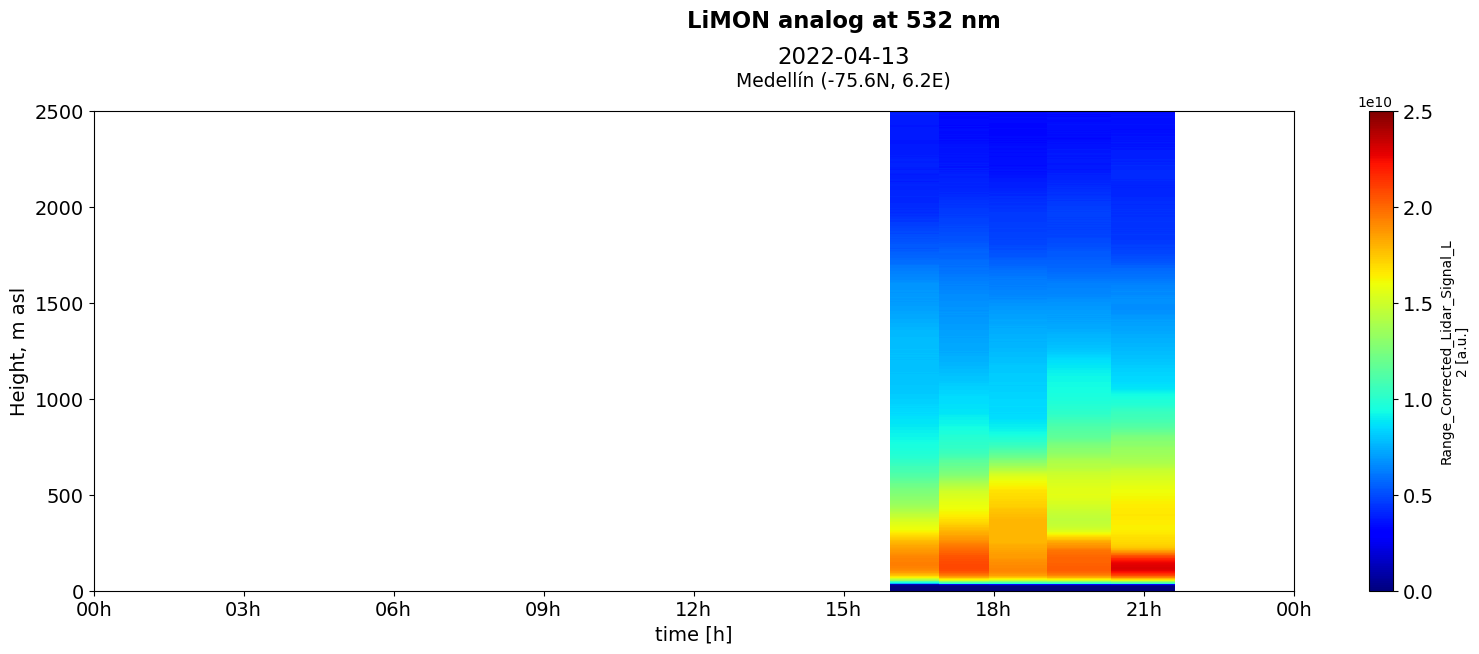

In [13]:
# filenames = [r'C:\Users\Sebastian\Googledrive2\Mi unidad\TRABAJO DE GRADO - SCE\TFG\Datos de autores\kabl-master (Thomas Rieutord)\data-samples\lidar\DAILY_MPL_5025_20180802.nc',
#              r'C:\Users\Sebastian\Googledrive2\Mi unidad\TRABAJO DE GRADO - SCE\TFG\Datos de autores\kabl-master (Thomas Rieutord)\data-samples\lidar\DAILY_MPL_5029_20180224.nc']

# filenames = [r'/home/user/Escritorio/data-samples/lidar/DAILY_MPL_5025_20180802.nc',
#              r'/home/user/Escritorio/data-samples/lidar/DAILY_MPL_5029_20180224.nc']


# blh_human_path = r'/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-human/'
# blh_human_path = r'C:\Users\\Sebastian\Googledrive2\Mi unidad\TRABAJO DE GRADO - SCE\TFG\Datos de autores\kabl-master (Thomas Rieutord)\data-samples\blh-from-human\\'
# blh_human_path = r'/home/user/Escritorio/data-samples/blh-from-human/'

for filename in filenames:
  # date = filename.split('/')[-1].split('.')[0].split('_')[-1]

  # pdb.set_trace()
  ncfile = nc.Dataset(filename)
  group = ncfile.groups['L2_Data']
  ds = xr.open_dataset(xr.backends.NetCDF4DataStore(group))
  global_attributes = {attr: ncfile.getncattr(attr) for attr in ncfile.ncattrs()}

  start_time = ds.Start_Time_AVG_L2.values.astype('float32') // 10**9
  stop_time = ds.Stop_Time_AVG_L2.values

  avg_time = (start_time + stop_time) / 2

  datetime_ns = np.array(avg_time, dtype='datetime64[s]')
  datetime_ns = datetime_ns.astype('datetime64[ns]') 

  ds = ds.assign_coords(time=datetime_ns)


  qt = 'RCS'
  wl = '532'
  signal_mode = 'analog'
  channel = 'Range_Corrected_Lidar_Signal_L2'

  fig, axes = plt.subplots(nrows=1, figsize=(15,6))

  plot_as_me(ds=ds.sel(range=slice(0, 2500)),
            channel=channel,
            axes=axes,
            qt=qt,
            wl=wl,
            signal_mode=signal_mode,
            attrs=global_attributes,
            vmax=2.5e10,
            vmin=0,
            )
  # pdb.set_trace()
  # blh_human_filename = glob.glob(blh_human_path + '*' + date + '*')[0]
  # blh_human = pd.read_csv(blh_human_filename)
  # blh_human.t_values = blh_human.t_values.apply(pd.Timestamp.fromtimestamp)

  # plt.scatter(blh_human.t_values, blh_human.blh_ref, c='purple', s=None, marker='*', label='blh_human')

  # plt.legend(fontsize=14)
  # pdb.set_trace()
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('time [h]', fontsize=14)
  axes.set_ylabel('Height, m asl', fontsize=14)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


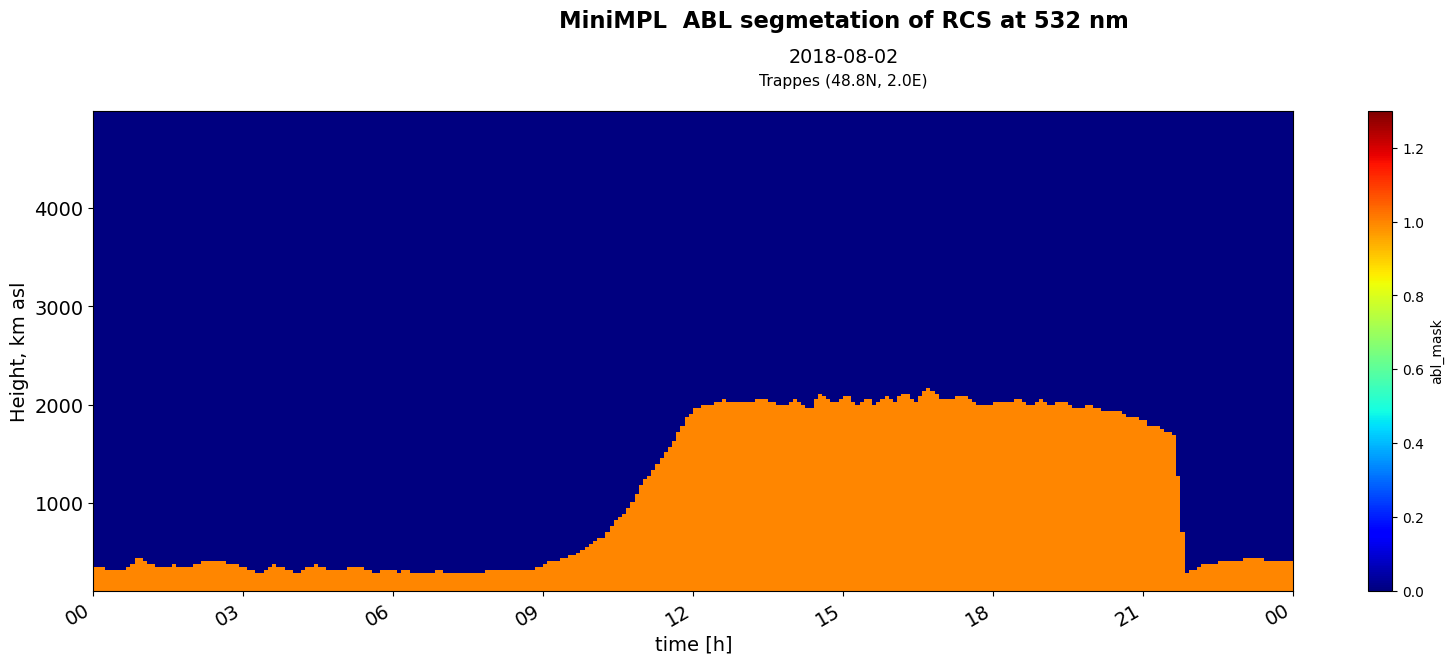

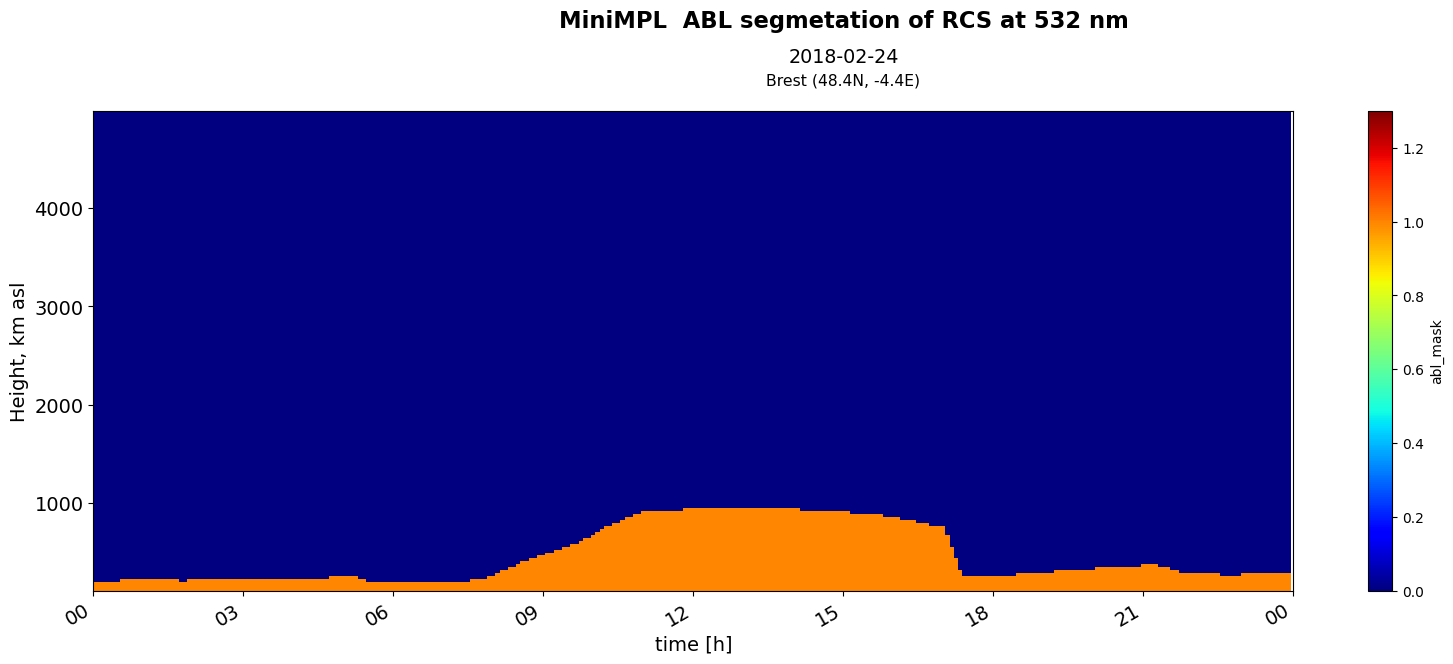

In [ ]:
for filename in filenames:
  date = filename.split('/')[-1].split('.')[0].split('_')[-1]

  ds = xr.load_dataset(filename)
  # ds = ds.assign_coords(range=ds.range/1000)
  site = site_location(float(ds.lat.data[0]), float(ds.lon.data[0]))

  qt = 'ABL segmetation of RCS'
  wl = '532'
  signal_mode = ''
  channel = ''


  fig, axes = plt.subplots(nrows=1, figsize=(15,6))

  blh_human_filename = glob.glob(blh_human_path + '*' + date + '*')[0]
  blh_human = pd.read_csv(blh_human_filename)
  blh_human.t_values = blh_human.t_values.apply(pd.Timestamp.fromtimestamp)

  mask = np.zeros(ds.rcs_0.shape)
  for idx, profile in enumerate(mask):
    mask[idx] = xr.where(ds.range < blh_human['blh_ref'][idx], 1, 0)
  ds = ds.assign({'abl_mask': (('time', 'range'), mask)})

  plot_as_me(ds=ds,
            channel='abl_mask',
            axes=axes,
            qt=qt,
            wl=wl,
            signal_mode=signal_mode,
            attrs=ds.attrs,
            vmax=1.3,
            vmin=0,
            )

  # pdb.set_trace()
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('time [h]', fontsize=14)
  axes.set_ylabel('Height, km asl', fontsize=14)

In [16]:
max_range = 2500

In [21]:
idt = np.arange(len(ds.time))
idz = np.arange(len(ds.sel(range=slice(0, max_range), channels=0).range))
idZ, idT_ = np.meshgrid(idz, idt)


p = stats.norm.pdf(ds.sel(range=slice(0, max_range), channels=0).range.values, 0, 5)        # Distribución Gaussiana
p = p / sum(p)                                                                  # Distribución Gaussiana


idx = np.random.choice(idz, idz.shape, replace=False)



np.apply_along_axis(np.random.shuffle, 1,idZ)



shuffled_X = np.array([profile[idZ[idi]].values for idi, profile in enumerate(normalize_ds(ds.sel(channels=0)["Range_Corrected_Lidar_Signal_L2"]))])
shuffled_y = np.array([profile[idZ[idi]].values for idi, profile in enumerate(ds.abl_mask)])

# shuffled_X = ds.rcs_0.sel(range=slice(0, max_range)).values
# shuffled_y = ds.abl_mask.sel(range=slice(0, max_range)).values


X_train = np.ravel(shuffled_X[:,idx[:int(len(idx)*0.6)]])
y_train = np.ravel(shuffled_y[:,idx[:int(len(idx)*0.6)]])

X_val = np.ravel(shuffled_X[:,idx[int(len(idx)*0.6): int(len(idx)*0.8)]])
y_val = np.ravel(shuffled_y[:,idx[int(len(idx)*0.6): int(len(idx)*0.8)]])

X_test = np.ravel(shuffled_X[:,idx[int(len(idx)*0.8):]])
y_test = np.ravel(shuffled_y[:,idx[int(len(idx)*0.8):]])



## Igualando en cantidad la porporsión de datos de la ABL y la FT:
## ===============================================================
train_mask = np.full(y_train.shape, False)
train_mask[np.where(y_train == 0)[0][:np.count_nonzero(y_train == 1)]] = True
train_mask[np.where(y_train == 1)[0]] = True
X_train = X_train[train_mask]
y_train = y_train[train_mask]
id_train = np.arange(len(y_train))
np.random.shuffle(id_train)
X_train = X_train[id_train]
y_train = y_train[id_train]

val_mask = np.full(y_val.shape, False)
val_mask[np.where(y_val == 0)[0][:np.count_nonzero(y_val == 1)]] = True
val_mask[np.where(y_val == 1)[0]] = True
X_val = X_val[val_mask]
y_val = y_val[val_mask]
id_val = np.arange(len(y_val))
np.random.shuffle(id_val)
X_val = X_val[id_val]
y_val = y_val[id_val]

test_mask = np.full(y_test.shape, False)
test_mask[np.where(y_test == 0)[0][:np.count_nonzero(y_test == 1)]] = True
test_mask[np.where(y_test == 1)[0]] = True
X_test = X_test[test_mask]
y_test = y_test[test_mask]
id_test = np.arange(len(y_test))
np.random.shuffle(id_test)
X_test = X_test[id_test]
y_test = y_test[id_test]



AttributeError: 'Dataset' object has no attribute 'abl_mask'

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4178,), (4178,), (1318,), (1318,), (1340,), (1340,))

AttributeError: ignored

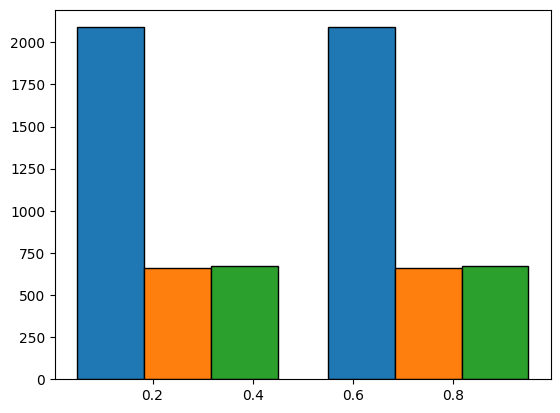

In [ ]:
#plt.hist([y_train, y_val, y_test], bins=3, histtype='bar', label=['Train', 'Validation', 'Test'])


n, bins, patches = plt.hist([y_train, y_val, y_test], bins=2, align='mid', edgecolor='black', label=['Train', 'Validation', 'Test'])

ticks = [(patch._x0 + patch._x1)/2 for patch in patches[1]]
ticklabels = ['FT', 'ABL']
plt.xticks(ticks, ticklabels)

# plt.hist(y_val, bins=5, label='Muestreado y mezclado (distribución unforme)', alpha=0.5)
# plt.hist(y_test, bins=5, label='Muestreado y mezclado (distribución unforme)', alpha=0.5)
plt.legend(fontsize=12)
plt.title(r'Disposición final de $|S|$', fontsize=14)
plt.xlabel('Etiquetas numéricas', fontsize=12)
plt.ylabel('Cantidad de datos', fontsize=12)

In [23]:
ds = apply_fft_ds(ds, channel='Range_Corrected_Lidar_Signal_L2')
X1 = ds.Range_Corrected_Lidar_Signal_L2.sel(range=slice(0,max_range))
X1_shape = X1.shape
X1 = normalize_ds(X1, vectorize_flag=False)
X1 = np.ravel(X1)
X1 = X1.reshape((-1, 1))


lidar_fft = np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))
X2 = normalize_ds(lidar_fft, vectorize_flag=False)
X2 = np.ravel(X2)
X2 = X2.reshape((-1, 1))


Z = ds.Range_Corrected_Lidar_Signal_L2.sel(range=slice(0,max_range)).range#**2
Z = normalize_ds(Z, vectorize_flag=False)
Z = np.tile(Z, X1_shape[0])
Z = Z.reshape((-1,1))
X = np.hstack((X1, Z))
# X = np.hstack((X1, X2))
# pdb.set_trace()

KeyError: 'long_name'

## Espacio original

### 4 Algoritmos


#### Mountain Clustering

In [22]:
def mountain_clustering(X, grid_n_partition=5, n_clusters=2, sigma=0.5, beta=1, dist_funct=euclidean, save_flag=False, out_dir=''):
  m, n = X.shape
  d = np.zeros((m, n_clusters))
  V_shape = (grid_n_partition,) * n

  # beta = sigma*8
  cords = np.tile(np.linspace(0, 1, grid_n_partition), (n, 1))

  V = np.array(np.meshgrid(*cords))
  C = []
  M = np.zeros(V_shape)

  for indice, a_ in np.ndenumerate(V[0]):
    vertice = np.array([v[indice] for v in V])
    M[indice] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*vertice), 2) / (2*sigma**2)))



  for ite in range(n_clusters):

    if M.max()<0.1:
      break

    c_cords = np.unravel_index(M.argmax(), M.shape)
    c = np.array([v[c_cords] for v in V])
    C.append(c)
    # pdb.set_trace()

    # V_vec = np.array([V[:, i, j] for i in range(V_shape[0]) for j in range(V_shape[1])])
    V_vec = np.array([[v[indice] for v in V] for indice, a_ in np.ndenumerate(V[0])])
    # pdb.set_trace()


    ###### VISUALIZACIÓN ######
    # fig = plt.figure()
    # plt.scatter(X[:, 0], X[:, 1], s=1)

    # plt.show()

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=60)
    # pdb.set_trace()
    ax.plot_surface(V[0], V[1], M, cmap=cm.coolwarm)
    # fig.title('Mountain Density')

    fig = plt.figure(figsize=(5,5))
    montain = plt.pcolormesh(V[0], V[1], M, cmap=cm.coolwarm)
    for c in C:
      plt.scatter(c[0], c[1], s=90, edgecolor='black')
    plt.colorbar(montain)
    # pdb.set_trace()
    ##################################################

    M = M - M[c_cords] * np.exp(-1* (np.power(np.reshape(dist_funct(V_vec, c), V_shape), 2)) / (2*beta**2))

  for i in range(len(C)):
    d[:,i] = dist_funct(X, C[i])

  U = d.copy()

  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0

  print('Número de clusters encontrados: ', len(C))

  return np.array(C), U

##### Euclidean

In [15]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=4/15, dist_funct=euclidean, n_clusters=7)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

# pdb.set_trace()
ds = ds.assign({'abl_mask_mc_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_EU', axes=axes, title='ABL clusters means Mountain Clustering with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))


plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

n_capas_euclidean = len(np.unique(ds.abl_mask_mc_EU))
print('Número de capas encontradas: ', n_capas_euclidean)

NameError: name 'X' is not defined

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Manhattan

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=manhattan, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_mc_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_MA', axes=axes, title='ABL clusters means Mountain Clustering with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


n_capas_manhattan = len(np.unique(ds.abl_mask_mc_MA))
print('Número de capas encontradas: ', n_capas_manhattan)

In [ ]:
time = ds.time[150].values

In [ ]:
fig, ax = plt.subplots(figsize=[20,7])

ax1 = plt.subplot(1,6,(1))


# ax1.plot(ds[rcs[0]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='b', label='rcs profile at 532 nm')
# ax1.plot(ds[rcs[1]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='r', label='rcs profile at 1064 nm')

# ax1.legend(fontsize=10, loc='upper center')
# for lab in range(int(ds.abl_mask_mc_MA.max())):
#   # pdb.set_trace()
#   plt.scatter
#   # ax1.scatter(ds.rcs_0.sel(time=time, method='nearest').values[np.where(ds.abl_mask_mc_MA.sel(time=time).values==lab)], ds.range[np.where(ds.abl_mask_mc_MA.sel(time=time).values==lab)[1]]/1000, c=colors[lab], s=3, label='cluster {}'.format(lab))
# ax1.legend(fontsize=10)
# ax1.set_title('RCS profile')

colors = np.array(['red', 'green', 'blue', 'yellow', 'black', 'purple', 'brown', 'grey', 'magenta', 'pink'])
# pdb.set_trace()
ax1.scatter(ds.rcs_0.sel(time=time, range=slice(0, max_range)), ds.sel(range=slice(0, max_range)).range, c=colors[ds.abl_mask_mc_MA.sel(time=time, range=slice(0, max_range)).values.astype(np.int32)])

ax2 = plt.subplot(1,6,(2,6), sharey=ax1)

# pdb.set_trace()
plot_as_me(ds=ds.sel(range=slice(0, max_range)),
          channel='rcs_0',
          axes=ax2,
          qt=qt,
          wl=wl,
          signal_mode=signal_mode,
          attrs=ds.attrs,
          vmin=0,
          vmax=1.3,
          )


# Create rectangle x coordinates
endTime = time + np.timedelta64(1, 's')
start = mpl.dates.date2num(time)
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, max_range, linewidth=2,color='red',fill=False)
ax2.add_patch(rect)

ax2.set_ylabel('')
ax1.set_ylabel('Height, m asl', fontsize=15)
ax1.set_xlabel('[a.u]', fontsize=15)
ax1.set_xlabel('[a.u]', fontsize=15)
o_ = plt.setp(ax2.get_yticklabels(), visible=False)
# u_ = plt.setp(ax1.get_yticklabels(), visible=False)

# year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-')
# hour = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').hour
# minute = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').minute
# out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
# fl_name = '{instru}_{qt}_with_profile at_{hour}{minute}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, hour=hour, minute=minute, wl=wl, mode=signal_mode, y=year, m=month, d=day)
# fl_name = os.path.join(out_dir, fl_name)
# plt.savefig(fl_name, dpi=200)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.8,
                    top=0.82,
                    wspace=0.4,
                    hspace=0.4)

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Mahalanobis

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=mahalanobis, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_mc_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_MAH', axes=axes, title='ABL clusters means Mountain Clustering with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

n_capas_mahalanobis = len(np.unique(ds.abl_mask_mc_MAH))
print('Número de capas encontradas: ', n_capas_mahalanobis)

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Cosine

Esta no funciona porque exíste una división por cero en el arlogrítmo dada esta métrica.

In [ ]:
# C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=cosine, n_clusters=10)

# fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(labels.argmax(axis=1).reshape(X1_shape).T)
# fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0, max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)
# plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 0]*80, C[:, 1])

#### K-means

In [ ]:
def k_means(X, n_clusters=4, delta=1e-6, n_iter=100, dist_funct=euclidean):
  m, n = X.shape
  C = np.random.rand(n_clusters, n)

  U = np.zeros((m, n_clusters))
  d = np.zeros((m, n_clusters))
  # pdb.set_trace()
  J = []
  for iter in range(n_iter):
    # print(C)
    for i in range(n_clusters):
      d[:,i] = dist_funct(X, C[i])
    U[np.arange(len(U)), d.argmax(axis=1)] = 1
    U[np.arange(len(U)), d.argmin(axis=1)] = 0
    # pdb.set_trace()

    # J_i[:,i] = dist_funct(X, C[i])

    J.append((U * np.power(d, 2)).sum())
    if len(J) > 1:
      if abs(J[-1] - J[-2] < delta):
        print('Interación final: ', iter)
        break
    # pdb.set_trace()

    for i in range(n_clusters):
      C[i] = (1/U[:, i].sum()) * (np.multiply(X, U[:, i].reshape((-1,1)))).sum(axis=0)

  return C, U


##### Euclidean

In [ ]:
n_capas_euclidean

In [ ]:
C, labels = k_means(X, dist_funct=euclidean, n_clusters=n_capas_euclidean)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_kmeans_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_EU', axes=axes, title='ABL clusters means K-means with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
C

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
C, labels = k_means(X, dist_funct=manhattan, n_clusters=n_capas_manhattan)

ds = ds.assign({'abl_mask_kmeans_MAN': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_MAN', axes=axes, title='ABL clusters means K-means with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1.3)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
C, labels = k_means(X, dist_funct=mahalanobis, n_clusters=n_capas_mahalanobis)

ds = ds.assign({'abl_mask_kmeans_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_MAH', axes=axes, title='ABL clusters means K-means with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
C, labels = k_means(X, dist_funct=cosine, n_clusters=n_capas_euclidean)

ds = ds.assign({'abl_mask_kmeans_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_CO', axes=axes, title='ABL clusters means K-means with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


#### Fuzzy C-means Clustering

In [ ]:
def FCM(X, n_clusters=2, delta=1e-6, e=1, n_iter=100, dist_funct=euclidean):
  m, n = X.shape
  m_exp = 24
  C = np.random.rand(n_clusters, n)

  U = np.random.rand(m, n_clusters)
  # pdb.set_trace()


  d = np.zeros((m, n_clusters))
  J = []
  for iter in range(n_iter):
    U = np.divide(U, U.sum(axis=1).reshape((-1,1)))
    for i in range(n_clusters):
      # pdb.set_trace()
      C[i] = (X * (U[:,i]**m_exp).reshape((-1,1))).sum(axis=0) / (U[:, i]**m_exp).sum()


    # print(C)
    for i in range(n_clusters):
      d[:,i] = dist_funct(X, C[i])
    # pdb.set_trace()

    # J_i[:,i] = dist_funct(X, C[i])

    J.append((np.power(U, e) * np.power(d, 2)).sum())
    # pdb.set_trace()

    if len(J) > 1:
      if abs(J[-1] - J[-2] < delta):
        print('Interación final: ', iter)
        break

    for k in range(n_clusters):
      U = 1 / (d / (d.sum(axis=1).reshape((-1,1))))**(2/(m_exp-1))


  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0
  return C, U


##### Euclidean

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=euclidean, e=3, n_clusters=n_capas_euclidean)

ds = ds.assign({'abl_mask_fcm_UE': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_UE', axes=axes, title='ABL clusters means FCM with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
C

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=manhattan, e=3, n_clusters=n_capas_manhattan)

ds = ds.assign({'abl_mask_fcm_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_MA', axes=axes, title='ABL clusters means FCM with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=mahalanobis, e=3, n_clusters=n_capas_mahalanobis)

ds = ds.assign({'abl_mask_fcm_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_MAH', axes=axes, title='ABL clusters means FCM with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=cosine, e=3, n_clusters=n_capas_euclidean)

ds = ds.assign({'abl_mask_fcm_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_CO', axes=axes, title='ABL clusters means FCM with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


#### Subtractive Clustering

In [ ]:
def subtractive_clustering(X, n_clusters=2, ra=0.1, dist_funct=euclidean, save_flag=False, out_dir=''):

  def calculate_D(X, m):
    D = np.zeros(m)
    # calculate_D(X)
    for idx, xi in enumerate(X):
      D[idx] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*xi), 2, dtype=np.float16) / ((ra/2)**2)))
    return D

  m, n = X.shape
  d = np.zeros((m, n_clusters))

  rb = ra*8

  # cords = np.tile(np.linspace(0, 1, grid_n_partition), (n, 1))
  V = np.array(np.meshgrid(X[:, 0], X[:, 1]))
  # pdb.set_trace()
  C = []
  # D = np.zeros(m)
  D = calculate_D(X=X, m=m)
  # for idx, xi in enumerate(X):
  #   D[idx] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*xi), 2, dtype=np.float16) / ((ra/2)**2)))

  # pdb.set_trace()
  for ite in range(n_clusters):
    if D.max()<0.1:
      break

    cid = D.argmax()
    C.append(X[cid])



    ###### VISUALIZACIÓN ######
    # # fig = plt.figure()
    # # plt.scatter(X[:, 0], X[:, 1], s=1)

    # # plt.show()

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.view_init(elev=45)
    # ax.plot_surface(V[0], V[1], np.diag(D), cmap=cm.coolwarm)
    # # pdb.set_trace()
    # # fig.title('Mountain Density')

    # fig = plt.figure()
    # montain = plt.pcolormesh(V[0], V[1], np.diag(D), cmap=cm.coolwarm)
    # for c in C:
    #   plt.scatter(c[0], c[1])
    # plt.colorbar(montain)
  #   ##################################################

    # pdb.set_trace()
    D = D - D[cid] * np.exp(-1* (np.power(dist_funct(X, X[cid]), 2)) / ((rb/2)**2))

  for i in range(len(C)):
    d[:,i] = dist_funct(X, C[i])

  U = d.copy()

  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0

  print('Número de clusters encontrados: ', len(C))

  # pdb.set_trace()
  return np.array(C), U


##### Euclidean

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=euclidean, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_sc_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_EU', axes=axes, title='ABL clusters means Subtactive Clustering with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))


plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
# ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=manhattan, n_clusters=10)

ds = ds.assign({'abl_mask_sc_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_MA', axes=axes, title='ABL clusters means Subtactive Clustering with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=mahalanobis, n_clusters=10)

ds = ds.assign({'abl_mask_sc_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_MAH', axes=axes, title='ABL clusters means Subtactive Clustering with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
# ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=cosine, n_clusters=10)

ds = ds.assign({'abl_mask_sc_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_CO', axes=axes, title='ABL clusters means Subtactive Clustering with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


## Reducción de dimensionalidad

### UMAP

In [ ]:
X.shape

In [ ]:
X = umap.UMAP().fit_transform(X)

In [ ]:
X = X.astype(np.float64)

In [ ]:
X[:, 0] = (X[:, 0] - X[:, 0].min()) / (X[:, 0].max() - X[:, 0].min())
X[:, 1] = (X[:, 1] - X[:, 1].min()) / (X[:, 1].max() - X[:, 1].min())

In [ ]:
X.shape

In [ ]:
X = X1.copy()
X.shape

### 4 Algoritmos


#### Mountain Clustering

In [ ]:
def mountain_clustering(X, grid_n_partition=5, n_clusters=2, sigma=0.5, beta=1, dist_funct=euclidean, save_flag=False, out_dir=''):
  m, n = X.shape
  d = np.zeros((m, n_clusters))
  V_shape = (grid_n_partition,) * n

  # beta = sigma*8
  cords = np.tile(np.linspace(0, 1, grid_n_partition), (n, 1))

  V = np.array(np.meshgrid(*cords))
  C = []
  M = np.zeros(V_shape)

  for indice, a_ in np.ndenumerate(V[0]):
    vertice = np.array([v[indice] for v in V])
    M[indice] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*vertice), 2) / (2*sigma**2)))



  for ite in range(n_clusters):

    if M.max()<0.1:
      break

    c_cords = np.unravel_index(M.argmax(), M.shape)
    c = np.array([v[c_cords] for v in V])
    C.append(c)
    # pdb.set_trace()

    # V_vec = np.array([V[:, i, j] for i in range(V_shape[0]) for j in range(V_shape[1])])
    V_vec = np.array([[v[indice] for v in V] for indice, a_ in np.ndenumerate(V[0])])
    # pdb.set_trace()


    ###### VISUALIZACIÓN ######
    # # fig = plt.figure()
    # # plt.scatter(X[:, 0], X[:, 1], s=1)

    # # plt.show()

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.view_init(elev=45)
    # # pdb.set_trace()
    # ax.plot_surface(V[0], V[1], M, cmap=cm.coolwarm)
    # # fig.title('Mountain Density')

    # fig = plt.figure()
    # montain = plt.pcolormesh(V[0], V[1], M, cmap=cm.coolwarm)
    # for c in C:
    #   plt.scatter(c[0], c[1])
    # plt.colorbar(montain)
    # # pdb.set_trace()
    ##################################################

    M = M - M[c_cords] * np.exp(-1* (np.power(np.reshape(dist_funct(V_vec, c), V_shape), 2)) / (2*beta**2))

  for i in range(len(C)):
    d[:,i] = dist_funct(X, C[i])

  U = d.copy()

  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0

  print('Número de clusters encontrados: ', len(C))

  return np.array(C), U

##### Euclidean

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=euclidean, n_clusters=7)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

# pdb.set_trace()
ds = ds.assign({'abl_mask_mc_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_EU', axes=axes, title='ABL clusters means Mountain Clustering with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))


plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])

n_capas_euclidean = len(np.unique(ds.abl_mask_mc_EU))
print('Número de capas encontradas: ', n_capas_euclidean)

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Manhattan

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=manhattan, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_mc_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_MA', axes=axes, title='ABL clusters means Mountain Clustering with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])


n_capas_manhattan = len(np.unique(ds.abl_mask_mc_MA))
print('Número de capas encontradas: ', n_capas_manhattan)

In [ ]:
time = ds.time[150].values

In [ ]:
fig, ax = plt.subplots(figsize=[20,7])

ax1 = plt.subplot(1,6,(1))


# ax1.plot(ds[rcs[0]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='b', label='rcs profile at 532 nm')
# ax1.plot(ds[rcs[1]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='r', label='rcs profile at 1064 nm')

# ax1.legend(fontsize=10, loc='upper center')
# for lab in range(int(ds.abl_mask_mc_MA.max())):
#   # pdb.set_trace()
#   plt.scatter
#   # ax1.scatter(ds.rcs_0.sel(time=time, method='nearest').values[np.where(ds.abl_mask_mc_MA.sel(time=time).values==lab)], ds.range[np.where(ds.abl_mask_mc_MA.sel(time=time).values==lab)[1]]/1000, c=colors[lab], s=3, label='cluster {}'.format(lab))
# ax1.legend(fontsize=10)
# ax1.set_title('RCS profile')

colors = np.array(['red', 'green', 'blue', 'yellow', 'black', 'purple', 'brown', 'grey', 'magenta', 'pink'])
# pdb.set_trace()
ax1.scatter(ds.rcs_0.sel(time=time, range=slice(0, max_range)), ds.sel(range=slice(0, max_range)).range, c=colors[ds.abl_mask_mc_MA.sel(time=time, range=slice(0, max_range)).values.astype(np.int32)])

ax2 = plt.subplot(1,6,(2,6), sharey=ax1)

# pdb.set_trace()
plot_as_me(ds=ds.sel(range=slice(0, max_range)),
          channel='rcs_0',
          axes=ax2,
          qt=qt,
          wl=wl,
          signal_mode=signal_mode,
          attrs=ds.attrs,
          vmin=0,
          vmax=1.3,
          )


# Create rectangle x coordinates
endTime = time + np.timedelta64(1, 's')
start = mpl.dates.date2num(time)
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, max_range, linewidth=2,color='red',fill=False)
ax2.add_patch(rect)

ax2.set_ylabel('')
ax1.set_ylabel('Height, m asl', fontsize=15)
ax1.set_xlabel('[a.u]', fontsize=15)
ax1.set_xlabel('[a.u]', fontsize=15)
o_ = plt.setp(ax2.get_yticklabels(), visible=False)
# u_ = plt.setp(ax1.get_yticklabels(), visible=False)

# year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-')
# hour = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').hour
# minute = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').minute
# out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
# fl_name = '{instru}_{qt}_with_profile at_{hour}{minute}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, hour=hour, minute=minute, wl=wl, mode=signal_mode, y=year, m=month, d=day)
# fl_name = os.path.join(out_dir, fl_name)
# plt.savefig(fl_name, dpi=200)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.8,
                    top=0.82,
                    wspace=0.4,
                    hspace=0.4)

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Mahalanobis

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=mahalanobis, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_mc_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_MAH', axes=axes, title='ABL clusters means Mountain Clustering with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])

n_capas_mahalanobis = len(np.unique(ds.abl_mask_mc_MAH))
print('Número de capas encontradas: ', n_capas_mahalanobis)

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Cosine

Esta no funciona porque exíste una división por cero en el arlogrítmo dada esta métrica.

In [ ]:
# C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=cosine, n_clusters=10)

# fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(labels.argmax(axis=1).reshape(X1_shape).T)
# fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0, max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)
# plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

#### K-means

In [ ]:
def k_means(X, n_clusters=4, delta=1e-6, n_iter=100, dist_funct=euclidean):
  m, n = X.shape
  C = np.random.rand(n_clusters, n)

  U = np.zeros((m, n_clusters))
  d = np.zeros((m, n_clusters))
  # pdb.set_trace()
  J = []
  for iter in range(n_iter):
    # print(C)
    for i in range(n_clusters):
      d[:,i] = dist_funct(X, C[i])
    U[np.arange(len(U)), d.argmax(axis=1)] = 1
    U[np.arange(len(U)), d.argmin(axis=1)] = 0
    # pdb.set_trace()

    # J_i[:,i] = dist_funct(X, C[i])

    J.append((U * np.power(d, 2)).sum())
    if len(J) > 1:
      if abs(J[-1] - J[-2] < delta):
        print('Interación final: ', iter)
        break
    # pdb.set_trace()

    for i in range(n_clusters):
      C[i] = (1/U[:, i].sum()) * (np.multiply(X, U[:, i].reshape((-1,1)))).sum(axis=0)

  return C, U


##### Euclidean

In [ ]:
n_capas_euclidean

In [ ]:
C, labels = k_means(X, dist_funct=euclidean, n_clusters=n_capas_euclidean)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_kmeans_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_EU', axes=axes, title='ABL clusters means K-means with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
C

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
n_capas_manhattan

In [ ]:
C, labels = k_means(X, dist_funct=manhattan, n_clusters=n_capas_manhattan)

ds = ds.assign({'abl_mask_kmeans_MAN': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_MAN', axes=axes, title='ABL clusters means K-means with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1.3)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
n_capas_mahalanobis

In [ ]:
C, labels = k_means(X, dist_funct=mahalanobis, n_clusters=n_capas_mahalanobis)

ds = ds.assign({'abl_mask_kmeans_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_MAH', axes=axes, title='ABL clusters means K-means with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
# C, labels = k_means(X, dist_funct=cosine, n_clusters=n_capas_euclidean)

# ds = ds.assign({'abl_mask_kmeans_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


# fig, axes = plt.subplots(nrows=1, figsize=(15,6))

# plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_CO', axes=axes, title='ABL clusters means K-means with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

# fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# # plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

# plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


# plt.show()

# # plt.plot(X[:,0].reshape(X1_shape)[0])
# # plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
# SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
# CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

# true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
# ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

# print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


#### Fuzzy C-means Clustering

In [ ]:
def FCM(X, n_clusters=2, delta=1e-6, e=1, n_iter=100, dist_funct=euclidean):
  m, n = X.shape
  m_exp = 24
  C = np.random.rand(n_clusters, n)

  U = np.random.rand(m, n_clusters)
  # pdb.set_trace()


  d = np.zeros((m, n_clusters))
  J = []
  for iter in range(n_iter):
    U = np.divide(U, U.sum(axis=1).reshape((-1,1)))
    for i in range(n_clusters):
      # pdb.set_trace()
      C[i] = (X * (U[:,i]**m_exp).reshape((-1,1))).sum(axis=0) / (U[:, i]**m_exp).sum()


    # print(C)
    for i in range(n_clusters):
      d[:,i] = dist_funct(X, C[i])
    # pdb.set_trace()

    # J_i[:,i] = dist_funct(X, C[i])

    J.append((np.power(U, e) * np.power(d, 2)).sum())
    # pdb.set_trace()

    if len(J) > 1:
      if abs(J[-1] - J[-2] < delta):
        print('Interación final: ', iter)
        break

    for k in range(n_clusters):
      U = 1 / (d / (d.sum(axis=1).reshape((-1,1))))**(2/(m_exp-1))


  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0
  return C, U


##### Euclidean

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=euclidean, e=3, n_clusters=n_capas_euclidean)

ds = ds.assign({'abl_mask_fcm_UE': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_UE', axes=axes, title='ABL clusters means FCM with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
C

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=manhattan, e=3, n_clusters=n_capas_manhattan)

ds = ds.assign({'abl_mask_fcm_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_MA', axes=axes, title='ABL clusters means FCM with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=mahalanobis, e=3, n_clusters=n_capas_mahalanobis)

ds = ds.assign({'abl_mask_fcm_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_MAH', axes=axes, title='ABL clusters means FCM with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
# C, labels = C, labels = FCM(X, dist_funct=cosine, e=3, n_clusters=n_capas_euclidean)

# ds = ds.assign({'abl_mask_fcm_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


# fig, axes = plt.subplots(nrows=1, figsize=(15,6))

# plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_CO', axes=axes, title='ABL clusters means FCM with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

# fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# # plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

# plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


# plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
# SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
# CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

# true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
# ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

# print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


#### Subtractive Clustering

In [ ]:
def subtractive_clustering(X, n_clusters=2, ra=0.1, dist_funct=euclidean, save_flag=False, out_dir=''):
  # @numba.jit(nopython=True)
  def calculate_D(X, m):
    D = np.zeros(m)
    # calculate_D(X)
    for idx, xi in enumerate(X):
      D[idx] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*xi), 2, dtype=np.float16) / ((ra/2)**2)))
    return D

  m, n = X.shape
  d = np.zeros((m, n_clusters))

  rb = ra*2

  # cords = np.tile(np.linspace(0, 1, grid_n_partition), (n, 1))
  # V = np.array(np.meshgrid(X[:, 0], X[:, 1]))
  C = []
  # D = np.zeros(m)
  D = calculate_D(X=X, m=m)
  # pdb.set_trace()
  # for idx, xi in enumerate(X):
  #   D[idx] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*xi), 2, dtype=np.float16) / ((ra/2)**2)))

  # pdb.set_trace()
  for ite in range(n_clusters):
    if D.max()<0.1:
      break

    cid = D.argmax()
    C.append(X[cid])



    ###### VISUALIZACIÓN ######
    # # fig = plt.figure()
    # # plt.scatter(X[:, 0], X[:, 1], s=1)

    # # plt.show()

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.view_init(elev=45)
    # ax.plot_surface(V[0], V[1], np.diag(D), cmap=cm.coolwarm)
    # # pdb.set_trace()
    # # fig.title('Mountain Density')

    # fig = plt.figure()
    # montain = plt.pcolormesh(V[0], V[1], np.diag(D), cmap=cm.coolwarm)
    # for c in C:
    #   plt.scatter(c[0], c[1])
    # plt.colorbar(montain)
  #   ##################################################

    # pdb.set_trace()
    D = D - D[cid] * np.exp(-1* (np.power(dist_funct(X, X[cid]), 2)) / ((rb/2)**2))

  for i in range(len(C)):
    d[:,i] = dist_funct(X, C[i])

  U = d.copy()

  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0

  print('Número de clusters encontrados: ', len(C))

  # pdb.set_trace()
  return np.array(C), U


##### Euclidean

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=euclidean, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_sc_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_EU', axes=axes, title='ABL clusters means Subtactive Clustering with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))


plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
# ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=manhattan, n_clusters=10)

ds = ds.assign({'abl_mask_sc_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_MA', axes=axes, title='ABL clusters means Subtactive Clustering with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=mahalanobis, n_clusters=10)

ds = ds.assign({'abl_mask_sc_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_MAH', axes=axes, title='ABL clusters means Subtactive Clustering with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
# ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
# n_profiles = 288
# C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=cosine, n_clusters=10)

# ds = ds.assign({'abl_mask_sc_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


# fig, axes = plt.subplots(nrows=1, figsize=(15,6))

# plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_CO', axes=axes, title='ABL clusters means Subtactive Clustering with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

# fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# # plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

# plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


# plt.show()

# # plt.plot(X[:,0].reshape(X1_shape)[0])
# # plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


## Aumento de dimensionalidad

### Muestreo

In [ ]:
ds = apply_fft_ds(ds, channel='rcs_0')
X1 = ds.rcs_1.sel(range=slice(0,max_range))
X1_shape = X1.shape
X1 = normalize_ds(X1, vectorize_flag=False)
X1 = np.ravel(X1)
X1 = X1.reshape((-1, 1))


lidar_fft_Re = np.real(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))
lidar_fft_Im = np.imag(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))

# pdb.set_trace()

X2 = ds.rcs_2.sel(range=slice(0,max_range))
X2_shape = X2.shape
X2 = normalize_ds(X2, vectorize_flag=False)
X2 = np.ravel(X2)
X2 = X2.reshape((-1, 1))

# X3 = normalize_ds(lidar_fft_Im, vectorize_flag=False)
# X3 = np.ravel(X3)
# X3 = X3.reshape((-1, 1))


Z = ds.rcs_0.sel(range=slice(0,max_range)).range#**2
Z = normalize_ds(Z, vectorize_flag=False)
Z = np.tile(Z, X1_shape[0])
Z = Z.reshape((-1,1))
X = np.hstack((X1, X2, Z))
# X = np.hstack((X1, X2))
# pdb.set_trace()

In [ ]:
X.shape

### 4 Algoritmos


#### Mountain Clustering

In [ ]:
def mountain_clustering(X, grid_n_partition=5, n_clusters=2, sigma=0.5, beta=1, dist_funct=euclidean, save_flag=False, out_dir=''):
  m, n = X.shape
  d = np.zeros((m, n_clusters))
  V_shape = (grid_n_partition,) * n

  # beta = sigma*8
  cords = np.tile(np.linspace(0, 1, grid_n_partition), (n, 1))

  V = np.array(np.meshgrid(*cords))
  C = []
  M = np.zeros(V_shape)

  for indice, a_ in np.ndenumerate(V[0]):
    vertice = np.array([v[indice] for v in V])
    M[indice] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*vertice), 2) / (2*sigma**2)))



  for ite in range(n_clusters):

    if M.max()<0.1:
      break

    c_cords = np.unravel_index(M.argmax(), M.shape)
    c = np.array([v[c_cords] for v in V])
    C.append(c)
    # pdb.set_trace()

    # V_vec = np.array([V[:, i, j] for i in range(V_shape[0]) for j in range(V_shape[1])])
    V_vec = np.array([[v[indice] for v in V] for indice, a_ in np.ndenumerate(V[0])])
    # pdb.set_trace()


    ###### VISUALIZACIÓN ######
    # fig = plt.figure()
    # plt.scatter(X[:, 0], X[:, 1], s=1)

    # plt.show()

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.view_init(elev=45)
    # # pdb.set_trace()
    # ax.plot_surface(V[0], V[1], M, cmap=cm.coolwarm)
    # # fig.title('Mountain Density')

    # fig = plt.figure()
    # montain = plt.pcolormesh(V[0], V[1], M, cmap=cm.coolwarm)
    # for c in C:
    #   plt.scatter(c[0], c[1])
    # plt.colorbar(montain)
    # pdb.set_trace()
    ##################################################

    M = M - M[c_cords] * np.exp(-1* (np.power(np.reshape(dist_funct(V_vec, c), V_shape), 2)) / (2*beta**2))

  for i in range(len(C)):
    d[:,i] = dist_funct(X, C[i])

  U = d.copy()

  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0

  print('Número de clusters encontrados: ', len(C))

  return np.array(C), U

##### Euclidean

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=euclidean, n_clusters=7)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

# pdb.set_trace()
ds = ds.assign({'abl_mask_mc_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_EU', axes=axes, title='ABL clusters means Mountain Clustering with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))


plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

n_capas_euclidean = len(np.unique(ds.abl_mask_mc_EU))
print('Número de capas encontradas: ', n_capas_euclidean)

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Manhattan

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=manhattan, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_mc_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_MA', axes=axes, title='ABL clusters means Mountain Clustering with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


n_capas_manhattan = len(np.unique(ds.abl_mask_mc_MA))
print('Número de capas encontradas: ', n_capas_manhattan)

In [ ]:
time = ds.time[100].values

In [ ]:
fig, ax = plt.subplots(figsize=[20,7])

ax1 = plt.subplot(1,6,(1))


# ax1.plot(ds[rcs[0]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='b', label='rcs profile at 532 nm')
# ax1.plot(ds[rcs[1]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='r', label='rcs profile at 1064 nm')

# ax1.legend(fontsize=10, loc='upper center')
# for lab in range(int(ds.abl_mask_mc_MA.max())):
#   # pdb.set_trace()
#   plt.scatter
#   # ax1.scatter(ds.rcs_0.sel(time=time, method='nearest').values[np.where(ds.abl_mask_mc_MA.sel(time=time).values==lab)], ds.range[np.where(ds.abl_mask_mc_MA.sel(time=time).values==lab)[1]]/1000, c=colors[lab], s=3, label='cluster {}'.format(lab))
# ax1.legend(fontsize=10)
# ax1.set_title('RCS profile')

colors = np.array(['red', 'green', 'blue', 'yellow', 'black', 'purple', 'brown', 'grey', 'magenta', 'pink'])
# pdb.set_trace()
ax1.scatter(ds.rcs_0.sel(time=time, range=slice(0, max_range)), ds.sel(range=slice(0, max_range)).range, c=colors[ds.abl_mask_mc_MA.sel(time=time, range=slice(0, max_range)).values.astype(np.int32)])

ax2 = plt.subplot(1,6,(2,6), sharey=ax1)

# pdb.set_trace()
plot_as_me(ds=ds.sel(range=slice(0, max_range)),
          channel='rcs_0',
          axes=ax2,
          qt=qt,
          wl=wl,
          signal_mode=signal_mode,
          attrs=ds.attrs,
          vmin=0,
          vmax=1.3,
          )


# Create rectangle x coordinates
endTime = time + np.timedelta64(1, 's')
start = mpl.dates.date2num(time)
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, max_range, linewidth=2,color='red',fill=False)
ax2.add_patch(rect)

ax2.set_ylabel('')
ax1.set_ylabel('Height, m asl', fontsize=15)
ax1.set_xlabel('[a.u]', fontsize=15)
ax1.set_xlabel('[a.u]', fontsize=15)
o_ = plt.setp(ax2.get_yticklabels(), visible=False)
# u_ = plt.setp(ax1.get_yticklabels(), visible=False)

# year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-')
# hour = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').hour
# minute = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').minute
# out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
# fl_name = '{instru}_{qt}_with_profile at_{hour}{minute}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, hour=hour, minute=minute, wl=wl, mode=signal_mode, y=year, m=month, d=day)
# fl_name = os.path.join(out_dir, fl_name)
# plt.savefig(fl_name, dpi=200)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.8,
                    top=0.82,
                    wspace=0.4,
                    hspace=0.4)

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Mahalanobis

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=mahalanobis, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_mc_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_MAH', axes=axes, title='ABL clusters means Mountain Clustering with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

n_capas_mahalanobis = len(np.unique(ds.abl_mask_mc_MAH))
print('Número de capas encontradas: ', n_capas_mahalanobis)

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Cosine

Esta no funciona porque exíste una división por cero en el arlogrítmo dada esta métrica.

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=cosine, n_clusters=10)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
plt.pcolormesh(labels.argmax(axis=1).reshape(X1_shape).T)
fig, axes = plt.subplots(nrows=1, figsize=(15,6))
plt.pcolormesh(ds.rcs_0.sel(range=slice(0, max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)
plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 0]*80, C[:, 1])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


#### K-means

In [ ]:
def k_means(X, n_clusters=4, delta=1e-6, n_iter=100, dist_funct=euclidean):
  m, n = X.shape
  C = np.random.rand(n_clusters, n)

  U = np.zeros((m, n_clusters))
  d = np.zeros((m, n_clusters))
  # pdb.set_trace()
  J = []
  for iter in range(n_iter):
    # print(C)
    for i in range(n_clusters):
      d[:,i] = dist_funct(X, C[i])
    U[np.arange(len(U)), d.argmax(axis=1)] = 1
    U[np.arange(len(U)), d.argmin(axis=1)] = 0
    # pdb.set_trace()

    # J_i[:,i] = dist_funct(X, C[i])

    J.append((U * np.power(d, 2)).sum())
    if len(J) > 1:
      if abs(J[-1] - J[-2] < delta):
        print('Interación final: ', iter)
        break
    # pdb.set_trace()

    for i in range(n_clusters):
      C[i] = (1/U[:, i].sum()) * (np.multiply(X, U[:, i].reshape((-1,1)))).sum(axis=0)

  return C, U


##### Euclidean

In [ ]:
n_capas_euclidean

In [ ]:
C, labels = k_means(X, dist_funct=euclidean, n_clusters=n_capas_euclidean)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_kmeans_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_EU', axes=axes, title='ABL clusters means K-means with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
C

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
C, labels = k_means(X, dist_funct=manhattan, n_clusters=n_capas_manhattan)

ds = ds.assign({'abl_mask_kmeans_MAN': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_MAN', axes=axes, title='ABL clusters means K-means with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1.3)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
C, labels = k_means(X, dist_funct=mahalanobis, n_clusters=n_capas_mahalanobis)

ds = ds.assign({'abl_mask_kmeans_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_MAH', axes=axes, title='ABL clusters means K-means with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
C, labels = k_means(X, dist_funct=cosine, n_clusters=n_capas_euclidean)

ds = ds.assign({'abl_mask_kmeans_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_CO', axes=axes, title='ABL clusters means K-means with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


#### Fuzzy C-means Clustering

In [ ]:
def FCM(X, n_clusters=2, delta=1e-6, e=1, n_iter=100, dist_funct=euclidean):
  m, n = X.shape
  m_exp = 24
  C = np.random.rand(n_clusters, n)

  U = np.random.rand(m, n_clusters)
  # pdb.set_trace()


  d = np.zeros((m, n_clusters))
  J = []
  for iter in range(n_iter):
    U = np.divide(U, U.sum(axis=1).reshape((-1,1)))
    for i in range(n_clusters):
      # pdb.set_trace()
      C[i] = (X * (U[:,i]**m_exp).reshape((-1,1))).sum(axis=0) / (U[:, i]**m_exp).sum()


    # print(C)
    for i in range(n_clusters):
      d[:,i] = dist_funct(X, C[i])
    # pdb.set_trace()

    # J_i[:,i] = dist_funct(X, C[i])

    J.append((np.power(U, e) * np.power(d, 2)).sum())
    # pdb.set_trace()

    if len(J) > 1:
      if abs(J[-1] - J[-2] < delta):
        print('Interación final: ', iter)
        break

    for k in range(n_clusters):
      U = 1 / (d / (d.sum(axis=1).reshape((-1,1))))**(2/(m_exp-1))


  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0
  return C, U


##### Euclidean

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=euclidean, e=3, n_clusters=n_capas_euclidean)

ds = ds.assign({'abl_mask_fcm_UE': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_UE', axes=axes, title='ABL clusters means FCM with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
C

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=manhattan, e=3, n_clusters=n_capas_manhattan)

ds = ds.assign({'abl_mask_fcm_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_MA', axes=axes, title='ABL clusters means FCM with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=mahalanobis, e=3, n_clusters=n_capas_mahalanobis)

ds = ds.assign({'abl_mask_fcm_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_MAH', axes=axes, title='ABL clusters means FCM with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=cosine, e=3, n_clusters=n_capas_euclidean)

ds = ds.assign({'abl_mask_fcm_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_CO', axes=axes, title='ABL clusters means FCM with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


#### Subtractive Clustering

In [ ]:
def subtractive_clustering(X, n_clusters=2, ra=0.1, dist_funct=euclidean, save_flag=False, out_dir=''):

  def calculate_D(X, m):
    D = np.zeros(m)
    # calculate_D(X)
    for idx, xi in enumerate(X):
      D[idx] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*xi), 2, dtype=np.float16) / ((ra/2)**2)))
    return D

  m, n = X.shape
  d = np.zeros((m, n_clusters))

  rb = ra*8

  # cords = np.tile(np.linspace(0, 1, grid_n_partition), (n, 1))
  V = np.array(np.meshgrid(X[:, 0], X[:, 1]))
  # pdb.set_trace()
  C = []
  # D = np.zeros(m)
  D = calculate_D(X=X, m=m)
  # for idx, xi in enumerate(X):
  #   D[idx] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*xi), 2, dtype=np.float16) / ((ra/2)**2)))

  # pdb.set_trace()
  for ite in range(n_clusters):
    if D.max()<0.1:
      break

    cid = D.argmax()
    C.append(X[cid])



    ###### VISUALIZACIÓN ######
    # # fig = plt.figure()
    # # plt.scatter(X[:, 0], X[:, 1], s=1)

    # # plt.show()

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.view_init(elev=45)
    # ax.plot_surface(V[0], V[1], np.diag(D), cmap=cm.coolwarm)
    # # pdb.set_trace()
    # # fig.title('Mountain Density')

    # fig = plt.figure()
    # montain = plt.pcolormesh(V[0], V[1], np.diag(D), cmap=cm.coolwarm)
    # for c in C:
    #   plt.scatter(c[0], c[1])
    # plt.colorbar(montain)
  #   ##################################################

    # pdb.set_trace()
    D = D - D[cid] * np.exp(-1* (np.power(dist_funct(X, X[cid]), 2)) / ((rb/2)**2))

  for i in range(len(C)):
    d[:,i] = dist_funct(X, C[i])

  U = d.copy()

  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0

  print('Número de clusters encontrados: ', len(C))

  # pdb.set_trace()
  return np.array(C), U


##### Euclidean

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=euclidean, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_sc_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_EU', axes=axes, title='ABL clusters means Subtactive Clustering with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))


plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
# ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=manhattan, n_clusters=10)

ds = ds.assign({'abl_mask_sc_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_MA', axes=axes, title='ABL clusters means Subtactive Clustering with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=mahalanobis, n_clusters=10)

ds = ds.assign({'abl_mask_sc_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_MAH', axes=axes, title='ABL clusters means Subtactive Clustering with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
# ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.005, dist_funct=cosine, n_clusters=10)

ds = ds.assign({'abl_mask_sc_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_CO', axes=axes, title='ABL clusters means Subtactive Clustering with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
plt.scatter(X[:, 0], X[:, 1])

## Solo polarización

### Muestreo

In [ ]:
ds = apply_fft_ds(ds, channel='rcs_0')
X1 = ds.rcs_1.sel(range=slice(0,max_range))
X1_shape = X1.shape
X1 = normalize_ds(X1, vectorize_flag=False)
X1 = np.ravel(X1)
X1 = X1.reshape((-1, 1))


lidar_fft_Re = np.real(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))
lidar_fft_Im = np.imag(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))

# pdb.set_trace()

X2 = ds.rcs_2.sel(range=slice(0,max_range))
X2_shape = X2.shape
X2 = normalize_ds(X2, vectorize_flag=False)
X2 = np.ravel(X2)
X2 = X2.reshape((-1, 1))

# X3 = normalize_ds(lidar_fft_Im, vectorize_flag=False)
# X3 = np.ravel(X3)
# X3 = X3.reshape((-1, 1))


Z = ds.rcs_0.sel(range=slice(0,max_range)).range#**2
Z = normalize_ds(Z, vectorize_flag=False)
Z = np.tile(Z, X1_shape[0])
Z = Z.reshape((-1,1))
X = np.hstack((X1, X2))
# X = np.hstack((X1, X2))
# pdb.set_trace()

In [ ]:
X.shape

### 4 Algoritmos


#### Mountain Clustering

In [ ]:
def mountain_clustering(X, grid_n_partition=5, n_clusters=2, sigma=0.5, beta=1, dist_funct=euclidean, save_flag=False, out_dir=''):
  m, n = X.shape
  d = np.zeros((m, n_clusters))
  V_shape = (grid_n_partition,) * n

  # beta = sigma*8
  cords = np.tile(np.linspace(0, 1, grid_n_partition), (n, 1))

  V = np.array(np.meshgrid(*cords))
  C = []
  M = np.zeros(V_shape)

  for indice, a_ in np.ndenumerate(V[0]):
    vertice = np.array([v[indice] for v in V])
    M[indice] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*vertice), 2) / (2*sigma**2)))



  for ite in range(n_clusters):

    if M.max()<0.1:
      break

    c_cords = np.unravel_index(M.argmax(), M.shape)
    c = np.array([v[c_cords] for v in V])
    C.append(c)
    # pdb.set_trace()

    # V_vec = np.array([V[:, i, j] for i in range(V_shape[0]) for j in range(V_shape[1])])
    V_vec = np.array([[v[indice] for v in V] for indice, a_ in np.ndenumerate(V[0])])
    # pdb.set_trace()


    ###### VISUALIZACIÓN ######
    fig = plt.figure()
    plt.scatter(X[:, 0], X[:, 1], s=1)

    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=45)
    # pdb.set_trace()
    ax.plot_surface(V[0], V[1], M, cmap=cm.coolwarm)
    # fig.title('Mountain Density')

    fig = plt.figure()
    montain = plt.pcolormesh(V[0], V[1], M, cmap=cm.coolwarm)
    for c in C:
      plt.scatter(c[0], c[1])
    plt.colorbar(montain)
    # pdb.set_trace()
    ##################################################

    M = M - M[c_cords] * np.exp(-1* (np.power(np.reshape(dist_funct(V_vec, c), V_shape), 2)) / (2*beta**2))

  for i in range(len(C)):
    d[:,i] = dist_funct(X, C[i])

  U = d.copy()

  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0

  print('Número de clusters encontrados: ', len(C))

  return np.array(C), U

##### Euclidean

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=euclidean, n_clusters=7)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

# pdb.set_trace()
ds = ds.assign({'abl_mask_mc_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_EU', axes=axes, title='ABL clusters means Mountain Clustering with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))


plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

n_capas_euclidean = len(np.unique(ds.abl_mask_mc_EU))
print('Número de capas encontradas: ', n_capas_euclidean)

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Manhattan

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=manhattan, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_mc_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_MA', axes=axes, title='ABL clusters means Mountain Clustering with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


n_capas_manhattan = len(np.unique(ds.abl_mask_mc_MA))
print('Número de capas encontradas: ', n_capas_manhattan)

In [ ]:
time = ds.time[100].values

In [ ]:
fig, ax = plt.subplots(figsize=[20,7])

ax1 = plt.subplot(1,6,(1))


# ax1.plot(ds[rcs[0]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='b', label='rcs profile at 532 nm')
# ax1.plot(ds[rcs[1]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='r', label='rcs profile at 1064 nm')

# ax1.legend(fontsize=10, loc='upper center')
# for lab in range(int(ds.abl_mask_mc_MA.max())):
#   # pdb.set_trace()
#   plt.scatter
#   # ax1.scatter(ds.rcs_0.sel(time=time, method='nearest').values[np.where(ds.abl_mask_mc_MA.sel(time=time).values==lab)], ds.range[np.where(ds.abl_mask_mc_MA.sel(time=time).values==lab)[1]]/1000, c=colors[lab], s=3, label='cluster {}'.format(lab))
# ax1.legend(fontsize=10)
# ax1.set_title('RCS profile')

colors = np.array(['red', 'green', 'blue', 'yellow', 'black', 'purple', 'brown', 'grey', 'magenta', 'pink'])
# pdb.set_trace()
ax1.scatter(ds.rcs_0.sel(time=time, range=slice(0, max_range)), ds.sel(range=slice(0, max_range)).range, c=colors[ds.abl_mask_mc_MA.sel(time=time, range=slice(0, max_range)).values.astype(np.int32)])

ax2 = plt.subplot(1,6,(2,6), sharey=ax1)

# pdb.set_trace()
plot_as_me(ds=ds.sel(range=slice(0, max_range)),
          channel='rcs_0',
          axes=ax2,
          qt=qt,
          wl=wl,
          signal_mode=signal_mode,
          attrs=ds.attrs,
          vmin=0,
          vmax=1.3,
          )


# Create rectangle x coordinates
endTime = time + np.timedelta64(1, 's')
start = mpl.dates.date2num(time)
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, max_range, linewidth=2,color='red',fill=False)
ax2.add_patch(rect)

ax2.set_ylabel('')
ax1.set_ylabel('Height, m asl', fontsize=15)
ax1.set_xlabel('[a.u]', fontsize=15)
ax1.set_xlabel('[a.u]', fontsize=15)
o_ = plt.setp(ax2.get_yticklabels(), visible=False)
# u_ = plt.setp(ax1.get_yticklabels(), visible=False)

# year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-')
# hour = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').hour
# minute = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').minute
# out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
# fl_name = '{instru}_{qt}_with_profile at_{hour}{minute}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, hour=hour, minute=minute, wl=wl, mode=signal_mode, y=year, m=month, d=day)
# fl_name = os.path.join(out_dir, fl_name)
# plt.savefig(fl_name, dpi=200)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.8,
                    top=0.82,
                    wspace=0.4,
                    hspace=0.4)

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Mahalanobis

In [ ]:
C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=mahalanobis, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_mc_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_mc_MAH', axes=axes, title='ABL clusters means Mountain Clustering with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

n_capas_mahalanobis = len(np.unique(ds.abl_mask_mc_MAH))
print('Número de capas encontradas: ', n_capas_mahalanobis)

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 0]*80, C[:, 1])

##### Cosine

Esta no funciona porque exíste una división por cero en el arlogrítmo dada esta métrica.

In [ ]:
# C, labels = mountain_clustering(X, grid_n_partition=15, sigma=1/15, beta=2/15, dist_funct=cosine, n_clusters=10)

# fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(labels.argmax(axis=1).reshape(X1_shape).T)
# fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0, max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)
# plt.show()

# plt.plot(X[:,0].reshape(X1_shape)[0])
# plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 0]*80, C[:, 1])

In [ ]:
# SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
# CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

# true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
# ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

# print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


#### K-means

In [ ]:
def k_means(X, n_clusters=4, delta=1e-6, n_iter=100, dist_funct=euclidean):
  m, n = X.shape
  C = np.random.rand(n_clusters, n)

  U = np.zeros((m, n_clusters))
  d = np.zeros((m, n_clusters))
  # pdb.set_trace()
  J = []
  for iter in range(n_iter):
    # print(C)
    for i in range(n_clusters):
      d[:,i] = dist_funct(X, C[i])
    U[np.arange(len(U)), d.argmax(axis=1)] = 1
    U[np.arange(len(U)), d.argmin(axis=1)] = 0
    # pdb.set_trace()

    # J_i[:,i] = dist_funct(X, C[i])

    J.append((U * np.power(d, 2)).sum())
    if len(J) > 1:
      if abs(J[-1] - J[-2] < delta):
        print('Interación final: ', iter)
        break
    # pdb.set_trace()

    for i in range(n_clusters):
      C[i] = (1/U[:, i].sum()) * (np.multiply(X, U[:, i].reshape((-1,1)))).sum(axis=0)

  return C, U


##### Euclidean

In [ ]:
n_capas_euclidean

In [ ]:
C, labels = k_means(X, dist_funct=euclidean, n_clusters=n_capas_euclidean)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_kmeans_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_EU', axes=axes, title='ABL clusters means K-means with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
C

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
C, labels = k_means(X, dist_funct=manhattan, n_clusters=n_capas_manhattan)

ds = ds.assign({'abl_mask_kmeans_MAN': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_MAN', axes=axes, title='ABL clusters means K-means with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1.3)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
C, labels = k_means(X, dist_funct=mahalanobis, n_clusters=n_capas_mahalanobis)

ds = ds.assign({'abl_mask_kmeans_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_MAH', axes=axes, title='ABL clusters means K-means with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
C, labels = k_means(X, dist_funct=cosine, n_clusters=n_capas_euclidean)

ds = ds.assign({'abl_mask_kmeans_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_kmeans_CO', axes=axes, title='ABL clusters means K-means with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


#### Fuzzy C-means Clustering

In [ ]:
def FCM(X, n_clusters=2, delta=1e-6, e=1, n_iter=100, dist_funct=euclidean):
  m, n = X.shape
  m_exp = 24
  C = np.random.rand(n_clusters, n)

  U = np.random.rand(m, n_clusters)
  # pdb.set_trace()


  d = np.zeros((m, n_clusters))
  J = []
  for iter in range(n_iter):
    U = np.divide(U, U.sum(axis=1).reshape((-1,1)))
    for i in range(n_clusters):
      # pdb.set_trace()
      C[i] = (X * (U[:,i]**m_exp).reshape((-1,1))).sum(axis=0) / (U[:, i]**m_exp).sum()


    # print(C)
    for i in range(n_clusters):
      d[:,i] = dist_funct(X, C[i])
    # pdb.set_trace()

    # J_i[:,i] = dist_funct(X, C[i])

    J.append((np.power(U, e) * np.power(d, 2)).sum())
    # pdb.set_trace()

    if len(J) > 1:
      if abs(J[-1] - J[-2] < delta):
        print('Interación final: ', iter)
        break

    for k in range(n_clusters):
      U = 1 / (d / (d.sum(axis=1).reshape((-1,1))))**(2/(m_exp-1))


  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0
  return C, U


##### Euclidean

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=euclidean, e=3, n_clusters=n_capas_euclidean)

ds = ds.assign({'abl_mask_fcm_UE': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_UE', axes=axes, title='ABL clusters means FCM with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
C

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=manhattan, e=3, n_clusters=n_capas_manhattan)

ds = ds.assign({'abl_mask_fcm_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_MA', axes=axes, title='ABL clusters means FCM with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])


In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=mahalanobis, e=3, n_clusters=n_capas_mahalanobis)

ds = ds.assign({'abl_mask_fcm_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_MAH', axes=axes, title='ABL clusters means FCM with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
C, labels = C, labels = FCM(X, dist_funct=cosine, e=3, n_clusters=n_capas_euclidean)

ds = ds.assign({'abl_mask_fcm_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_fcm_CO', axes=axes, title='ABL clusters means FCM with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


#### Subtractive Clustering

In [ ]:
def subtractive_clustering(X, n_clusters=2, ra=0.1, dist_funct=euclidean, save_flag=False, out_dir=''):

  def calculate_D(X, m):
    D = np.zeros(m)
    # calculate_D(X)
    for idx, xi in enumerate(X):
      D[idx] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*xi), 2, dtype=np.float16) / ((ra/2)**2)))
    return D

  m, n = X.shape
  d = np.zeros((m, n_clusters))

  rb = ra*8

  # cords = np.tile(np.linspace(0, 1, grid_n_partition), (n, 1))
  V = np.array(np.meshgrid(X[:, 0], X[:, 1]))
  # pdb.set_trace()
  C = []
  # D = np.zeros(m)
  D = calculate_D(X=X, m=m)
  # for idx, xi in enumerate(X):
  #   D[idx] = np.sum(np.exp(-1 * np.power(dist_funct(-1*X, -1*xi), 2, dtype=np.float16) / ((ra/2)**2)))

  # pdb.set_trace()
  for ite in range(n_clusters):
    if D.max()<0.1:
      break

    cid = D.argmax()
    C.append(X[cid])



    ###### VISUALIZACIÓN ######
    # # fig = plt.figure()
    # # plt.scatter(X[:, 0], X[:, 1], s=1)

    # # plt.show()

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.view_init(elev=45)
    # ax.plot_surface(V[0], V[1], np.diag(D), cmap=cm.coolwarm)
    # # pdb.set_trace()
    # # fig.title('Mountain Density')

    # fig = plt.figure()
    # montain = plt.pcolormesh(V[0], V[1], np.diag(D), cmap=cm.coolwarm)
    # for c in C:
    #   plt.scatter(c[0], c[1])
    # plt.colorbar(montain)
  #   ##################################################

    # pdb.set_trace()
    D = D - D[cid] * np.exp(-1* (np.power(dist_funct(X, X[cid]), 2)) / ((rb/2)**2))

  for i in range(len(C)):
    d[:,i] = dist_funct(X, C[i])

  U = d.copy()

  U[np.arange(len(U)), d.argmax(axis=1)] = 1
  U[np.arange(len(U)), d.argmin(axis=1)] = 0

  print('Número de clusters encontrados: ', len(C))

  # pdb.set_trace()
  return np.array(C), U


##### Euclidean

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=euclidean, n_clusters=10)
aux_ = np.zeros((ds.rcs_0.shape[0], ds.rcs_0.shape[1] -  ds.rcs_0.sel(range=slice(0, 2500)).shape[1]))

ds = ds.assign({'abl_mask_sc_EU': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_EU', axes=axes, title='ABL clusters means Subtactive Clustering with euclidean distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))


plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
# ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Manhattan

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=manhattan, n_clusters=10)

ds = ds.assign({'abl_mask_sc_MA': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_MA', axes=axes, title='ABL clusters means Subtactive Clustering with manhattan distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Mahalanobis

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.1, dist_funct=mahalanobis, n_clusters=10)

ds = ds.assign({'abl_mask_sc_MAH': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_MAH', axes=axes, title='ABL clusters means Subtactive Clustering with mahalanobis distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
# ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


##### Cosine

In [ ]:
n_profiles = 288
C, labels = subtractive_clustering(X[:80*n_profiles], ra=0.005, dist_funct=cosine, n_clusters=10)

ds = ds.assign({'abl_mask_sc_CO': (('time', 'range'), np.c_[labels.argmax(axis=1).reshape(X1_shape), aux_])})


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), channel='abl_mask_sc_CO', axes=axes, title='ABL clusters means Subtactive Clustering with cosine distance', attrs=ds.attrs, vmin=0, vmax=None, cmap=mpl.cm.viridis)

fig, axes = plt.subplots(nrows=1, figsize=(15,6))
# plt.pcolormesh(ds.rcs_0.sel(range=slice(0,max_range)).values.T, cmap='jet', vmin=0, vmax=1.3)

plot_as_me(ds.sel(range=slice(0, 2500)), channel='rcs_0', axes=axes, qt='range conrrected signal', wl='532', signal_mode='analog', attrs=ds.attrs, vmin=0, vmax=1)


plt.show()

plt.plot(X[:,0].reshape(X1_shape)[0])
plt.scatter(C[:, 1]*80, C[:, 0])

In [ ]:
SS = silhouette_score(X=X, labels=labels.argmax(axis=1))
CHS = calinski_harabasz_score(X=X, labels=labels.argmax(axis=1))

true_labels = np.ravel(ds.sel(range=slice(0, max_range)).abl_mask)
ARS = adjusted_rand_score(true_labels, labels.argmax(axis=1))

print('silhouette_score: ', SS, '\ncalinski_harabasz_score: ', CHS, '\nadjusted_rand_score: ', ARS)


In [ ]:
plt.scatter(X[:, 0], X[:, 1])